In [1]:
import sys

sys.path.insert(0, "..")
from Solver1D.Classes.Base import *

import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
import inspect
from tqdm import tqdm

And = Infix(ufl.And)


class Distr:

    def __init__(self, x: SpatialCoordinate, x0, slope):
        self.x = x
        self.x0 = x0
        self.slope = slope

    def create(self, kind: str):
        assert kind in Distr.kinds(get=True), 'Not implemented method'
        return getattr(self, kind)()

    @staticmethod
    def kinds(func=None, get=False, l=set()):
        if not get:
            l.add(func.__name__)
            return func
        else:
            return l

    def _singP(self):
        return (1 + ufl.sign(self.slope)) / 2

    def _singM(self):
        return (1 - ufl.sign(self.slope)) / 2

    @kinds
    def step(self):
        return conditional(
            self.x0 <= self.x,
            self._singP(),
            self._singM(),
        )

    @kinds
    def sigmoid(self):
        a = self.slope * 5
        return 1 / (1 + exp(-a * (self.x - self.x0)))

    @kinds
    def trapstep(self):
        a = self.slope
        res = conditional(
            (self.x0 - 1 / abs(2 * a) <= self.x)|And|
            (self.x < self.x0 + 1 / abs(2 * a)),
            a * (self.x - self.x0) + 0.5,
            0,
        )
        res += conditional(
            self.x0 + 1 / (2*a) <= self.x,
            self._singP(),
            self._singM(),
        )
        return res

    @kinds
    def parab(self):
        a = self.slope * 5
        res = conditional(
            (self.x0 - 1 / sqrt(abs(2 * a)) <= self.x)|And|(self.x < self.x0),
            a * (self.x - self.x0 + 1 / sqrt(abs(2 * a)))**2 + self._singM(),
            0,
        )
        res += conditional(
            (self.x0 <= self.x)|And|(self.x < self.x0 + 1 / sqrt(abs(2 * a)), ),
            -a * (self.x - self.x0 - 1 / sqrt(abs(2 * a)))**2 + self._singP(),
            0,
        )
        res += conditional(
            self.x0 + 1 / (ufl.sign(a) * sqrt(abs(2 * a))) <= self.x,
            self._singP(),
            self._singM()
        )
        return res


def function_plots(
    functions,
    fig=None,
    ax=None,
    show_points=False,
):
    """Create plot from fem.Function
    
    Args:
        fig (plt.Figure): Figure
        lists (fem.Function, str): List of (u, title)
        points_on (bool): If true create scatter
    """
    if (fig or ax) is None:
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(16, 8)
    for func in functions:
        x = func.function_space.tabulate_dof_coordinates()[:, 0]
        y = func.x.array
        cord = np.array([x, y])
        cord = cord[:, np.argsort(cord[0])]
        ax.plot(cord[0], cord[1], label=func.name, linewidth=1)
        if show_points: ax.scatter(cord[0], cord[1], s=0.5)
    ax.legend(
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0,
        loc='center left',
    )
    return ax


In [2]:
domain = mesh.create_interval(nx=100, comm=MPI.COMM_WORLD, points=[0, 1])
space = FunctionSpace(domain, ('CG', 1))
space2 = VectorFunctionSpace(domain, ('CG', 1))
x = SpatialCoordinate(space)[0]
set_connectivity(domain)

ds = Measure("ds", domain=domain)
norm = FacetNormal(domain)

u = TrialFunction(space)
v = TestFunction(space)
Distr.

f = Constant(space, 2)

F = (grad(u)|dot|grad(v)) * dx - (f*v) * dx
F -= (grad(u)|dot|norm) * v * ds

# bcs = [
#     DirichletBC(
#         space=space, form=Constant(space,1), combined_marker=lambda x: np.isclose(x[0], 0)
#     ),
#     DirichletBC(
#         space=space, form=Constant(space,1), combined_marker=lambda x: np.isclose(x[0], 1)
#     )
# ]
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=[],
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
    }
)

<AxesSubplot:>

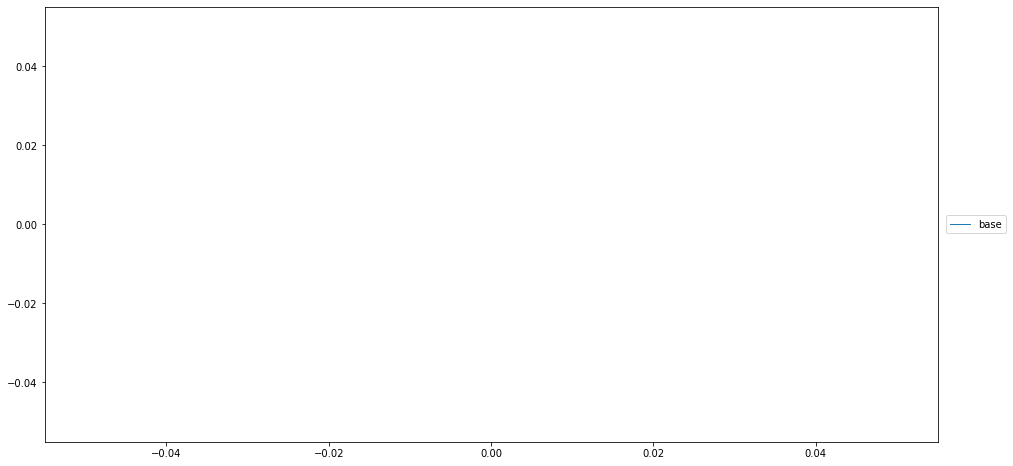

In [3]:
us =  problem.solve()
function_plots([Function(space, us,'base')])